In [12]:
#from numba import jit, cuda
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from random import gauss
%matplotlib inline

## Step 1: Generate Questions and Students
<ol>
    <li>Number of Student = S</li>
    <li>Number of Questions = C</li>
    <li>Number of Skills = K</li>
</ol>

In [13]:
# HYPERPARAMETERS
S = 50      # students
C = 10000   # questions
K = 10      # skills

<AxesSubplot:ylabel='Count'>

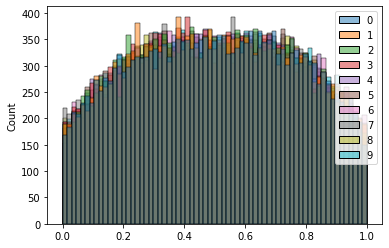

In [14]:
# APPROACH 1 -- Generate Students and Questions as independent variables
lower, upper = 0, 1
s_mu, s_sigma = 0.25, 0.15  # Mean in 0.25 since assumed low initial skills level
q_mu1, q_sigma1 = 0.25, 0.25
q_mu2, q_sigma2 = 0.75, 0.25
students = stats.truncnorm.rvs((lower-s_mu)/s_sigma,(upper-s_mu)/s_sigma,loc=s_mu,scale=s_sigma,size=(S,K))
questions = stats.truncnorm.rvs((lower-q_mu1)/q_sigma1,(upper-q_mu1)/q_sigma1,loc=q_mu1,scale=q_sigma1,size=(C,K))
questions = np.append(questions, stats.truncnorm.rvs((lower-q_mu2)/q_sigma2,(upper-q_mu2)/q_sigma2,loc=q_mu2,scale=q_sigma2,size=(C,K))).reshape(-1,K)
#questions = np.random.uniform(size=(C,K))
student_norms = np.linalg.norm(students, axis=1)
question_norms = np.linalg.norm(questions, axis=1)
sns.histplot(questions)

In [15]:
# # APPROACH 2 -- Generate Performance Matrix Y (S x C) and use MF to find students, questions
# lower, upper = 0, 1
# p_mu, p_sigma = 0.5, 0.20
# performance = stats.truncnorm.rvs((lower-p_mu)/p_sigma,(upper-p_mu)/p_sigma,loc=p_mu,scale=p_sigma,size=(S,C))
# #number_of_nan = 12500 # Half of the students
# #performance.ravel()[np.random.choice(performance.size, number_of_nan, replace=False)] = np.nan
# sns.heatmap(performance)
# # Matrix Factorization
# from sklearn.decomposition import NMF
# model = NMF(n_components=K, random_state=42, max_iter=10000)
# students = model.fit_transform(performance)
# questions = np.transpose(model.components_)

## For the time being better use approach 1
## Step 2: Model definition

In [16]:
import do_mpc
model_type = 'discrete'
model = do_mpc.model.Model(model_type)
# States
x = model.set_variable(var_type='_x', var_name='x', shape=(K,1))
z = model.set_variable(var_type='_z', var_name='z', shape=(K,1))
y = model.set_variable(var_type='_x', var_name='y', shape=(1,1))
#z2 = model.set_variable(var_type='_z', var_name='z2', shape=(1,1))
# Inputs
u = model.set_variable(var_type='_u', var_name='u', shape=(K,1))
# Outputs
#y = model.set_meas('y', shape=(1,1))
# Parameter for the MHE: Weighting of the arrival cost (parameters):
#P_p = model.set_variable(var_type='_p', var_name='P_p')
# Time-varying parameter for the MHE: Weighting of the measurements (tvp):
#P_v = model.set_variable(var_type='_tvp', var_name='P_v', shape=(5, 5))

In [17]:
# State measurements
y_meas = model.set_meas('y_meas', y, meas_noise=False)
# Model parameters --> required for mhe
#Theta_1 = model.set_variable('parameter', 'Theta_1')

In [18]:
def circ(x):
    return 1- sqrt(1 - (x-1)**2)
def gaussian(x, mu, sig):
    return exp(-((x - mu)**2) / (2 * (sig**2)))

def perturbate():
    val = np.random.normal(1, 0.4)
    val = 2 - val if val > 1 else val
    return val

In [19]:
from casadi import *
#x_next = SX()
rhs_x = []
rhs_y = []

gamma = 0.8 # Learning rate

alpha = []
x_tilde = []
y_tilde = []

for k in range(K):
    # i: student
    # j: content
    # k: skill

    u_k = u[k]  #
    x_k = x[k]

    print("For skill {}, x_ik = {}, and u_jk = {}".format(k, x_k, u_k))
    #print("For skill {}, model data[\'_x\']={}".format(k, vars(model)))

    # alpha: skill deficiency (for all k) of student_i, given knowledge_i and content_j (requirement)
    ## alpha is zero when x_ik > u_jk, between (0,1] otherwise
    #alpha = u_jk * fmax(1 - (x_ik / u_jk), 0)
    alpha_k = fmax(1 - x_k/u_k,0) * u_k # Between 0 and 1
    x_tilde_k = gaussian(alpha_k, (1-x_k)/2, (1-x_k)/5) * perturbate()
    y_tilde_k = 1 - alpha_k
    #alpha_k = gaussian(fmax(u_k - x_k,0), 0.5, 0.1)
    #print(alpha_k)
    #y_tilde_k = circ(alpha_k)
    #y_tilde_k = 1 - alpha_k
    #y_tilde_k = fmax(1 - alpha_k/x_k, 0)
    alpha.append(alpha_k)
    x_tilde.append(x_tilde_k)
    y_tilde.append(y_tilde_k)

# Deficiency and skill norms for estimated performance calculation
#alpha_norm = norm_2(vertcat(*alpha))   # but before alpha was a number, you need to do it outside the loop at the end
#phi_norm = norm_2(x) # same            

# Estimated performance
improvement = sum1(vertcat(*x_tilde))/K
performance = sum1(vertcat(*y_tilde))/K

for k in range(K):
    u_k = u[k]  #
    x_k = x[k]
    # Knowledge update term
    tau_k   =  improvement * alpha[k]# * (alpha[k] > 0)#y_tilde  * u_k
    #tau_k = y_tilde * gaussian(alpha[k], 0.5, 0.1) * gamma
    #scalar = scalar * scalar * integer_boolean * scalar

    # Append rule to list of right-hand-side equations
    rhs_x.append(x_k + tau_k)


x_next = vertcat(*rhs_x)
y = performance
model.set_rhs('x', x_next, process_noise=True)
model.set_rhs('y', y, process_noise=True)

For skill 0, x_ik = x_0, and u_jk = u_0
For skill 1, x_ik = x_1, and u_jk = u_1
For skill 2, x_ik = x_2, and u_jk = u_2
For skill 3, x_ik = x_3, and u_jk = u_3
For skill 4, x_ik = x_4, and u_jk = u_4
For skill 5, x_ik = x_5, and u_jk = u_5
For skill 6, x_ik = x_6, and u_jk = u_6
For skill 7, x_ik = x_7, and u_jk = u_7
For skill 8, x_ik = x_8, and u_jk = u_8
For skill 9, x_ik = x_9, and u_jk = u_9


In [20]:
model.set_expression(expr_name='cost_x', expr=sum1(x**2))
model.set_expression(expr_name='alpha', expr=fmax(u - x,0))
#model.set_expression(expr_name='y_tilde', expr=circ(fmax(u - x,0)))
#model.set_expression(expr_name='y_tilde_tot', expr=sum1(vertcat(*y_tilde))/K)
#model.set_expression(expr_name='z', expr=u-x)
#model.set_expression(expr_name='cost_x', expr=sum1(fabs(x)))
#model.set_expression(expr_name='cost_u', expr=sum1(fabs(u)))
#model.set_expression(expr_name='z', expr=z-(u-x)) #z-sum1(u-x))
model.set_alg(expr_name='z', expr=z-(u-x))
#model.set_alg(expr_name='z_upper', expr=sum1(u-x)>0)

In [21]:
model.setup()

In [24]:
mhe = do_mpc.estimator.MHE(model)
setup_mhe = {
    't_step': 1,
    'n_horizon': 5,
    'store_full_solution': True,
    'meas_from_data': True
}
mhe.set_param(**setup_mhe)

Traceback (most recent call last):
  File "C:\Program Files\JetBrains\PyCharm 2021.1.3\plugins\python\helpers-pro\jupyter_debug\pydev_jupyter_utils.py", line 69, in attach_to_debugger
    debugger.prepare_to_run(enable_tracing_from_start=False)
TypeError: prepare_to_run() got an unexpected keyword argument 'enable_tracing_from_start'
Failed to connect to target debugger.


RuntimeError: .../casadi/core/sx_instantiator.cpp:460: Sparsities of v and vdef must match. Got v: 0x1 and vdef: 0x0.

In [ ]:
P_v = 0#np.diag(np.array([1]))   # Output Noise
P_x = np.eye(K+1)                    # State weiggt
P_p = 10*np.eye(1)                 # Parameter weight
P_w = np.eye(K+1)   # Process Noise

mhe.set_default_objective(P_x, None, None, P_w)

In [ ]:
mhe.bounds['lower','_x', 'y'] = 0
mhe.bounds['upper','_x', 'y'] = 1

In [ ]:
mhe.setup()

In [ ]:
mpc=do_mpc.controller.MPC(model)
setup_mpc = {
    'n_horizon': 5,
    't_step': 1,
    'n_robust': 0,
    'state_discretization': 'discrete',
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

In [ ]:
lterm = -1*model.aux['cost_x']
mterm = -1*model.aux['cost_x']
mpc.set_objective(mterm=mterm, lterm=lterm)
#mpc.set_rterm(u=0)

In [ ]:
# Lower bounds on states:
mpc.bounds['lower','_x', 'x'] = 0

# Upper bounds on states
mpc.bounds['upper','_x', 'x'] = 1

# Lower bounds on skill deficiency:
mpc.bounds['lower','_z', 'z'] = 0
# # # # Upper bounds on skill deficiency:
mpc.bounds['upper','_z', 'z'] = 0.15

# Lower bounds on inputs:
mpc.bounds['lower','_u', 'u'] = 0
# Upper bounds on inputs:
mpc.bounds['upper','_u', 'u'] = 1

In [ ]:
mpc.setup()


In [ ]:
simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(t_step=1)

In [ ]:
simulator.setup()


In [ ]:
#estimator = do_mpc.estimator.StateFeedback(model)
x0 = np.append(students[4], np.random.uniform(0,1))
#mpc.x0 = x0
mhe.x0_mhe = x0
simulator.x0 = x0
#estimator.x0 = x0
mhe.set_initial_guess()


In [ ]:
import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 
from helper_funcs.distance_metrics import Similarity


In [ ]:
from helper_funcs.distance_metrics import Similarity

def question_selector(u_tilde):
    # Library of different similarity metrics to explore
    similarity_metrics = Similarity(minimum=1e-20)

    # Keeping track of best match and its distance to the optimal input
    min_diff = np.inf
    best_match = None

    # Brute force find the best matching question to the optimal one.
    for q in questions:
        '''
            On the Surprising Behavior of Distance Metrics in High Dimensional Space
            https://bib.dbvis.de/uploadedFiles/155.pdf
        '''
        # Calculate the question's similarity to the optimal solution:
        q_diff = similarity_metrics.fractional_distance(q, u_tilde, fraction=0.5)

        # Hold on to the temporary best match
        if q_diff < min_diff:
            min_diff = q_diff
            best_match = q
            
    return best_match.reshape(u_tilde.shape)

In [ ]:
%%capture
for i in range(50):
    u_tilde = mpc.make_step(x0)
    u = question_selector(u_tilde)
    y_next = simulator.make_step(u)
    x0 = estimator.make_step(y_next)

In [ ]:
mhe_graphics = do_mpc.graphics.Graphics(mhe.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)
#mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18

In [ ]:
%%capture
# We just want to create the plot and not show it right now. This "inline magic" surpresses the output.
fig, ax = plt.subplots(3, sharex=True, figsize=(16,9))
fig.align_ylabels()

# We create another figure to plot the parameters:
fig_p, ax_p = plt.subplots(1, figsize=(16,4))

In [ ]:
%%capture
for g in [sim_graphics, mhe_graphics]:
    # Plot the angle positions (phi_1, phi_2, phi_2) on the first axis:
    g.add_line(var_type='_x', var_name='x', axis=ax[0])
    ax[0].set_prop_cycle(None)
    g.add_line(var_type='_u', var_name='u', axis=ax[1])
    ax[1].set_prop_cycle(None)

    # Plot the set motor positions (phi_m_1_set, phi_m_2_set) on the second axis:
    g.add_line(var_type='_x', var_name='y', axis=ax[2])
    ax[2].set_prop_cycle(None)

    #g.add_line(var_type='_x', var_name='y_meas', axis=ax_p)


ax[0].set_ylabel('knowledge')
ax[1].set_ylabel('q. difficulty')
ax[2].set_ylabel('performance')
ax[2].set_xlabel('question #')

In [ ]:
sim_graphics.result_lines

In [ ]:
sim_graphics.result_lines['_x', 'x', 0]

In [ ]:
for line_i in sim_graphics.result_lines.full:
    line_i.set_alpha(0.4)
    line_i.set_linewidth(6)

In [ ]:
ax[0].legend(sim_graphics.result_lines['_x', 'x'], '123', title='Sim.', loc='center right')
ax[1].legend(mhe_graphics.result_lines['_x', 'x'], '123', title='MHE', loc='center right')

In [ ]:
def random_u(u0):
    # Hold the current value with 80% chance or switch to new random value.
    u_next = (0.5-np.random.rand(10,1))*np.pi # New candidate value.
    switch = np.random.rand() >= 0.8 # switching? 0 or 1.
    u0 = (1-switch)*u0 + switch*u_next # Old or new value.
    return u0

In [ ]:
%%capture
np.random.seed(999) #make it repeatable

u0 = np.zeros((10,1))
for i in range(50):
    u0 = random_u(u0) # Control input
    v0 = 0.1*np.random.randn(model.n_v,1) # measurement noise
    y0 = simulator.make_step(u0, v0=v0)
    x0 = mhe.make_step(y0) # MHE estimation step

In [ ]:
sim_graphics.plot_results()
mhe_graphics.plot_results()
# Reset the limits on all axes in graphic to show the data.
mhe_graphics.reset_axes()

# Mark the time after a full horizon is available to the MHE.
ax[0].axvline(1)
ax[1].axvline(1)
ax[2].axvline(1)

# Show the figure:
fig

In [ ]:
%%capture
fig, ax = plt.subplots(3, sharex=True, figsize=(16,12))
# Configure plot:
mpc_graphics.add_line(var_type='_x', var_name='x', axis=ax[0])
mpc_graphics.add_line(var_type='_u', var_name='u', axis=ax[1])
mpc_graphics.add_line(var_type='_aux', var_name='cost_x', axis=ax[2])
#mpc_graphics.add_line(var_type='_z', var_name='z', axis=ax[3])
ax[0].set_ylabel('Knowledge')
ax[1].set_ylabel('Question difficulty')
ax[2].set_ylabel('Total knowledge')
#ax[3].set_ylabel('Skill deficiency')
fig.align_ylabels()

In [ ]:
from matplotlib.animation import FuncAnimation, ImageMagickWriter

In [ ]:
def update(t_ind):
    print('Writing frame: {}.'.format(t_ind), end='\r')
    mpc_graphics.plot_results(t_ind=t_ind)
    mpc_graphics.plot_predictions(t_ind=t_ind)
    mpc_graphics.reset_axes()
    lines = mpc_graphics.result_lines.full
    return lines

n_steps = mpc.data['_time'].shape[0]


anim = FuncAnimation(fig, update, frames=n_steps, blit=True)

gif_writer = ImageMagickWriter(fps=5)
anim.save('simulation.gif', writer=gif_writer)

In [ ]:
import matplotlib.pyplot as plt
fig, ax, graphics = do_mpc.graphics.default_plot(mpc.data, figsize=(16,9), dpi=200)
graphics.reset_axes()
graphics.plot_results()
plt.show()

